In [2]:
using Pkg; Pkg.activate(".");

  Activating project at `~/julia_ws/PACMAN_ADworkshop/Day2`


Quick review on backward and forward mode
------------

We first consider a chain of functions:

$$
f(g(h(x))) = f(g(y)) = f(z) = F,
$$

with 

$$
\begin{cases}
h(x) = y \\
 g(y) = z \\ 
 f(z) = F
\end{cases}.
$$

Then the chain rule gives

$$
\frac{\partial F}{\partial x} = \frac{\partial F}{\partial z} \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}
$$


- ***Forward mode*** means that we compute the derivative as the <b>SAME</b> direction as evaluation, i.e.

$$
\frac{\partial y}{\partial x} \rightarrow \frac{\partial z}{\partial x} \rightarrow \frac{\partial F}{\partial x}
$$

- ***Backward mode*** means that we compute the derivative as the <b>REVERSE</b> direction as evaluation, i.e.

$$
\frac{\partial F}{\partial z} \rightarrow \frac{\partial F}{\partial y} \rightarrow \frac{\partial F}{\partial x}
$$

Backward mode : simple example
------------

Again we consider:

$$
f(x) = x \sin{(x^2)}
$$


Examples: Forward Euler with AD
------------

In this example, we demonstrate how to apply ForwardDiff.jl to analyze a simple ode. We first consider the ODE system with $x = x(t)$:

$$
\begin{cases}
x' = ax \\
x(0) = x_0
\end{cases}
$$
where $a > 0$ is the parameter of interest and $0 \leq t \leq 1$.

In what follows, we first apply a standard forward Euler scehem to integrate the ODE numerically, and evaluate the gradient with respect to parameter, which is often useful for sensitivity analysis.

... starting program ...


┌ Info: Saved animation to /tmp/jl_DglcRCxMNQ.gif
└ @ Plots /home/jerryho/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_DglcRCxMNQ.gif")
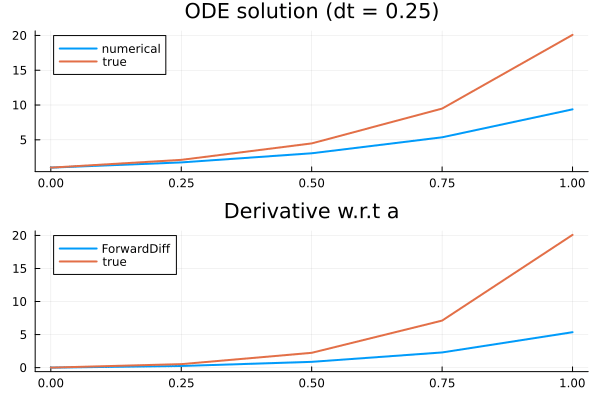

In [3]:
using Plots
using ForwardDiff

# solves ODE 
#   x' = a*x, x(0)=x0
# up to time T=1, with timestep dt, 
# using forward Euler
function odeexp(x0::Real, a::T, dt::Real) where T
    Nsteps = round(Int, 1 / dt)   # number of time steps
    sol = zeros(T, Nsteps + 1)
    x = x0
    sol[1] = x
    for t = 2:Nsteps+1
        x = x + a*x*dt
        sol[t] = x
    end
    return sol
end

println("... starting program ...")

# === parameters === 
x0 = 1.;  # initial condition
a = 3.;             # growth parameter
h = 0.5

##

@gif for p = 2:11
    dt = h ^ p
    Nsteps = round(Int, 1 / dt)
    t = [dt * k for k = 0:Nsteps]
    # === ODE solutions ===
    y = odeexp(x0, a, dt);  # numerical
    ytrue = x0 * exp.(a * t);  # true

    ##

    # === derivative with respect to a ===
    yd = x0*t.*exp.(a*t);   # true derivative

    ##

    # === numerical derivative ===
    f(a) = odeexp(x0, a, dt);
    ydiff = ForwardDiff.derivative(f, a);

    ##

    # === plot things ===
    p1 = plot(t, [y, ytrue], title="ODE solution (dt = $dt)", label=["numerical" "true"], linewidth=2)
    p2 = plot(t, [ydiff, yd], title="Derivative w.r.t a", label=["ForwardDiff" "true"], linewidth=2)
    p = plot(p1, p2, layout=(2,1))
end fps=3

Forward and backward mode in multivariate functions
------------

Consider again the chain of functions:

$$
f(g(h(x))) = f(g(y)) = f(z) = F,
$$

with 

$$
\begin{cases}
h(x) = y \\
 g(y) = z \\ 
 f(z) = F
\end{cases}.
$$

Then the chain rule gives

$$
\underbrace{\frac{\partial F}{\partial x}}_{|F| \times |x|} = \underbrace{\frac{\partial F}{\partial z}}_{|F| \times |z|} \underbrace{\frac{\partial z}{\partial y}}_{|z| \times |y|} \underbrace{\frac{\partial y}{\partial x}}_{|y| \times |x|}

$$

where the underbraces indicated the dimension of each Jacobian.

Pushforward and pullback
------------
(Ref: https://juliadiff.org/ChainRulesCore.jl/v0.9/#The-propagators:-pushforward-and-pullback)

Two fancy terms that the autodiff community adopted from Differential geometry. Understanding the terms "pushforward" and "pullback" in autodiff benefits from familiarity with their usage in differential geometry. However, even without prior knowledge, grasping their meaning in autodiff is feasible. 

Consider the above example with the chain of derivatives:

$$
\frac{\partial F}{\partial x} = \frac{\partial F}{\partial z} \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}
$$


The ***pushforward*** of $g$, where $g(y) = z$, incoperates the knowledge of $\frac{\partial z}{\partial y}$ and takes $\frac{\partial y}{\partial z}$ to $\frac{\partial z}{\partial x}$. i.e.

$$
\frac{\partial y}{\partial z} \xrightarrow{\frac{\partial z}{\partial y}} \frac{\partial z}{\partial x}
$$


Similarly, the ***pullback*** of $g$, where $g(y) = z$, incoperates the knowledge of $\frac{\partial z}{\partial y}$ and takes $\frac{\partial F}{\partial z}$ to $\frac{\partial F}{\partial y}$. i.e.

$$
\frac{\partial F}{\partial z} \xrightarrow{\frac{\partial z}{\partial y}} \frac{\partial F}{\partial y}.
$$

Multivariate reverse mode - simple example
------------

$$
f(x,y,z) = xz \sin{(xy)}
$$

Computational cost analysis
------------

- Recall: ***Forward mode*** means that we compute the derivative as the <b>SAME</b> direction as evaluation, i.e.

$$
\frac{\partial y}{\partial x} \rightarrow \frac{\partial z}{\partial x} \rightarrow \frac{\partial F}{\partial x}
$$

where we compute $\frac{\partial z}{\partial y}$ and $\frac{\partial F}{\partial z}$ in the first and second arrow respectively. Or, equivalently, 

$$
\frac{\partial F}{\partial x} = \frac{\partial F}{\partial z} \left(\frac{\partial z}{\partial y} \frac{\partial y}{\partial x}\right).
$$

What is the computational cost of evaluting $\frac{\partial F}{\partial x}$  as above? This involves:


- evaluating $\frac{\partial y}{\partial x}$, $\frac{\partial z}{\partial y}$ and $\frac{\partial F}{\partial z}$. (Note : we do not have to store the full Jacobian in practice!)
- $|x| \times |y| \times |z| + |x| \times |z| \times |F|$ multiplications

How about backward mode?

- ***Backward mode*** means that we compute the derivative as the <b>REVERSE</b> direction as evaluation, i.e.

$$
\frac{\partial F}{\partial z} \rightarrow \frac{\partial F}{\partial y} \rightarrow \frac{\partial F}{\partial x}
$$

where we compute $\frac{\partial z}{\partial y}$ and $\frac{\partial y}{\partial x}$ in the first and second arrow respectively. Or, equivalently, 

$$
\frac{\partial F}{\partial x} = \left(\frac{\partial F}{\partial z} \frac{\partial z}{\partial y}\right) \frac{\partial y}{\partial x}
$$

What is the computational cost of evaluting $\frac{\partial F}{\partial x}$  as above? This involves:


- evaluating $\frac{\partial y}{\partial x}$, $\frac{\partial z}{\partial y}$ and $\frac{\partial F}{\partial z}$
- $|F| \times |z| \times |y| + |F| \times |y| \times |x|$ multiplications


Hence, when $|F| \gg |x|$, <b>BACKWARD</b> mode is more efficient, and if $|x| \gg |F|$, <b>FORWARD</b> mode is preferred. 


***Note:*** In pratice, the ***optimal*** scheme would usually be a mixed mode differentiation.
